<a href="https://colab.research.google.com/github/AndySAnker/ML-MotEx/blob/main/StackingFaults/ML_StackingFaults.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to ML-MotEx
Github: https://github.com/AndySAnker/ML-MotEx/tree/main/StackingFaults

Paper: Characterisation of intergrowth in metal oxide materials using structure-mining: the case of γ-MnO2

Questions: andy@chem.ku.dk & nima@chem.ku.dk

Use this script to use ML-MotEx to extract a stacking fault distribution from a dataset. This script does both handle fits made on Pair Distribution Function (PDF) data and Powder X-ray Diffraction (PXRD) data.

The script first import packages and defines functions.

Section 1: We import the stacking fault sequences, stacking probabilities, volume fraction of the parent structures and their Rwp values. The following figure illustrates the data format.

![](https://github.com/AndySAnker/ML-MotEx/blob/main/StackingFaults/Images/Image1.png?raw=true)

Note: In the case of the study of γ-MnO2 intergrowth, the asymmetric units sequence and stacking faults sequence are different. We have therefore added both to the training dataset. They may be the same, e.g. in the case of a layered system.

Section 2: We train a gradient boosted decision tree to predict the Rwp value from the stacking fault sequences, stacking probabilities and volume fraction of the parent structures.

Section 3: We plot the importance of the blocks, stacking probabilities and volume fraction of the parent structures and why they are important. Do the model like specific blocks?

Section 4: We extract the information into two lists, "rather be ramsdellite (R-MnO2)/pyrolusite (β-MnO2) block". We calculate the stacking fault domains size distribution.

# Import modules and set seed parameters

In [17]:
%%capture
!pip install shap
!git clone https://github.com/AndySAnker/ML-MotEx.git
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time, random, shap, sklearn, os
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
random.seed(14)
np.random.seed(14)
os.chdir("ML-MotEx/StackingFaults")

# Define functions

In [18]:
def Train_XGBoost_XY(X_train, y_train, learning_rate, max_depth, n_estimators, n_jobs, gamma, min_child_weight, base_score, seed, xgb_model=None):
    start_time = time.time()
    model = xgb.XGBRegressor(learning_rate = learning_rate, max_depth=max_depth, n_estimators=n_estimators, n_jobs=n_jobs, gamma=gamma, min_child_weight=min_child_weight, base_score=base_score, random_state=seed)
    model.fit(X_train, y_train, xgb_model=xgb_model)
    print("Total execution time: %.3fs"%(time.time()-start_time))
    print ("Training Succeeded")
    return model
    
def Validate_XGBoost(model, X_val, y_val):
    print ("Giving an estimate of the accuracy of the model")
    y_pred_val = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
    print("RMSE: %f" % (rmse))
    return rmse

def shap_essential_figure(model, X_train):
    plt.clf()
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train) #to explain every prediction
    shap.summary_plot(shap_values, X_train, feature_names=names[2:], max_display=20, show=False) # to plot these explanations
    return explainer, shap_values

# 1 Import data ready for machine learning

In [19]:
fileName = "Training_Data/info_Intergrowth_ML_XRD_Diamond2h.txt"
Layers = 250

names = ['index', 'Rwp', 'Pb', 'Pr', 'percent_B', 'percent_R']+['Block_sequence'+str(i) for i in range(1, Layers+1)]+['Intergrowth_sequence'+str(i) for i in range(1, Layers+1)]
data = pd.read_csv(fileName, names=names, delimiter=" ") # Read data file
data = data.drop(data.columns[-1],axis=1) # Drop the last column with NANS
data = data.drop(data.columns[0],axis=1) # Drop index
data = data.replace(['P','R'], [0, 1]) # 0 is P, 1 is R

y = data['Rwp'] # Rwp is labels
X = data.drop(data.columns[0], axis=1) # Drop labels

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2) # Split the data into training and validation set

## Check that data is imported correct
Check 1: Is the number of training data 4 times larger than validation data?

Check 2: Print y_train and make sure it is the Rwp values of the fits.

Check 3: Print X_train and make sure that the first 5 entries are index, Pb, Pr, percent_B, percent_R. The next should be Block_sequence0, Block_sequence1, etc... the last should be Intergrowth_sequence0, Intergrowth_sequence1, etc...

In [20]:
# Check 1
print ("Number of Training Data:", len(X_train))
print ("Number of Validation Data:", len(X_val))

Number of Training Data: 3960
Number of Validation Data: 990


In [21]:
# Check 2
print (y_train.head())
print ()
print ("Stastical information about the Rwp distribution")
print (y_train.describe())

634     15.24904
2571    13.62155
3372    13.99128
1463    14.55927
1486    18.56308
Name: Rwp, dtype: float64

Stastical information about the Rwp distribution
count    3960.000000
mean       16.058357
std         2.434773
min        12.214000
25%        14.086435
50%        15.619260
75%        17.753375
max        26.120980
Name: Rwp, dtype: float64


In [22]:
# Check 3
X_train.head()

,Pb,Pr,percent_B,percent_R,Block_sequence1,Block_sequence2,Block_sequence3,Block_sequence4,Block_sequence5,Block_sequence6,...,Intergrowth_sequence240,Intergrowth_sequence241,Intergrowth_sequence242,Intergrowth_sequence243,Intergrowth_sequence244,Intergrowth_sequence245,Intergrowth_sequence246,Intergrowth_sequence247,Intergrowth_sequence248,Intergrowth_sequence249
634,0.13,0.84,0.155340,0.844660,1,2,2,1,2,1,...,1,1,1,0,1,1,1,1,1,0
2571,0.52,0.71,0.376623,0.623377,1,1,1,1,2,1,...,0,1,1,1,1,1,0,0,0,0
3372,0.68,0.72,0.466667,0.533333,1,1,2,2,2,2,...,1,1,1,1,1,1,1,1,1,0
1463,0.30,0.63,0.345794,0.654206,1,2,1,2,1,1,...,0,1,0,1,0,1,1,0,0,1
1486,0.30,0.86,0.166667,0.833333,1,1,2,1,1,2,...,1,1,1,1,1,1,1,1,1,1


# 2 Train the gradient boosted decision tree algorithm
The parameters can be changed in order to get the lowest possible root mean squared error (RMSE). Normally only learning rate and max_depth is changed. Max depth can only be changed as integers.

In [23]:
lr = 0.25 # 0.1 is default - Boosting learning rate
max_depth = 3 # 3 is default - Maximum tree depth for base learners.
n_estimators = 100 # 100 is default - Number of trees to fit. 
n_jobs = 1 # 1 is default - Number of parallel threads used to run xgboost.
gamma = 0 # 0 is default - Minimum loss reduction required to make a further partition on a leaf node of the tree.
min_child_weight = 1 # 1 is default - Minimum sum of instance weight(hessian) needed in a child.
base_score = 0.5 # 0.5 is default - The initial prediction score of all instances, global bias.
random_state = 0 # 0 is default - seeding

# Set up a ML algorithm based on the loaded permutations
model = Train_XGBoost_XY(X_train, y_train, learning_rate=lr, max_depth=max_depth, n_estimators=n_estimators, n_jobs=n_jobs, gamma=gamma, min_child_weight=min_child_weight, base_score=base_score, seed=random_state)
Validate_XGBoost(model, X_val, y_val)
model.save_model("ML_algorithms/Stacking_faults_manual_model.dat")

[08:17:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Total execution time: 5.358s
Training Succeeded
Giving an estimate of the accuracy of the model
RMSE: 0.909217


# 3 Plot how important the features (atoms) are in the structure and why they are important

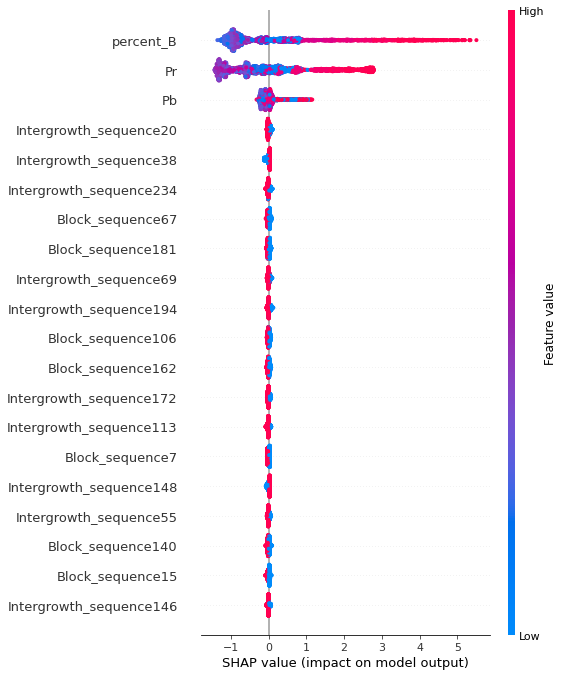

In [24]:
explainer, shap_values = shap_essential_figure(model, X_train.values)

# 4 Block Sequence

Best Sequences: (array([  1,   3,   6,   7,   8,  10,  11,  13,  14,  17,  19,  20,  23,
        26,  28,  33,  36,  38,  40,  41,  44,  48,  59,  61,  64,  66,
        67,  71,  72,  76,  80,  81,  83,  89,  96,  99, 102, 103, 104,
       105, 109, 110, 116, 117, 122, 123, 124, 125, 127, 129, 139, 142,
       144, 146, 148, 153, 161, 162, 163, 167, 169, 173, 175, 177, 179,
       180, 184, 188, 190, 192, 195, 198, 199, 203, 207, 208, 210, 213,
       216, 217, 220, 227, 228, 230, 233, 234, 236, 239, 240]),)
Worst Sequences: (array([  4,  31,  46,  75,  77,  95, 101, 108, 112, 114, 130, 141, 165,
       171, 176, 181, 185, 189, 204, 205, 232, 243, 248, 249]),)


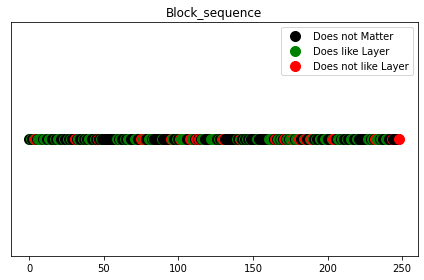

In [ ]:
# Calculate the layer contribution value for each layer
Block_sequence_list = []
for i in range(4, 4+1*Layers):
    a_shap = np.sum((shap_values[np.where(X_train.values[:,i] == 2),i]))
    b_shap = np.sum((shap_values[np.where(X_train.values[:,i] == 1),i]))
    Block_sequence_list.append(a_shap - b_shap)

lower_percentile = 0
print ("Best Sequences:", np.where((np.array(Block_sequence_list) < lower_percentile) & (np.array(Block_sequence_list) < 0)))
print ("Worst Sequences:", np.where((np.array(Block_sequence_list) > lower_percentile) & (np.array(Block_sequence_list) > 0)))

count_b = 0
count_g = 0
count_r = 0
for i in range(Layers-1):
    if Block_sequence_list[i] == 0:
        color = "k"
        label = "Does not Matter"
        plt.plot(i, 0, "o", color=color, markersize=10, label=label if count_b == 0 else "_nolegend_")
        count_b += 1
    elif Block_sequence_list[i] < lower_percentile:
        color = "g"
        label = "Does like Layer B"
        plt.plot(i, 0, "o", color=color, markersize=10, label=label if count_g == 0 else "_nolegend_")
        count_g += 1
    elif Block_sequence_list[i] > lower_percentile:
        color = "r"
        label = "Does like Layer A"
        plt.plot(i, 0, "o", color=color, markersize=10, label=label if count_r == 0 else "_nolegend_")
        count_r += 1

# Plot the results
plt.yticks([], [])
plt.legend()
plt.title("Block_sequence")
plt.tight_layout()
plt.show()

# Intergrowth sequence

R-MnO2 sequences: [ 10  12  19  24  31  33  34  39  42  46  54  59  60  61  68  70  72  73
  78  80  82  83  86  87  90  93  94  98  99 101 104 105 106 107 110 112
 113 115 117 118 119 120 121 123 126 127 130 132 133 134 137 138 139 140
 141 143 145 152 158 160 162 163 166 168 171 175 178 180 182 183 186 188
 192 193 198 199 200 201 204 206 209 211 216 217 221 222 225 226 229 230
 231 233 234 237 239 242 243 244 246]
B-MnO2 Sequences: [  1   2   4   6   7   9  11  20  21  23  28  32  36  37  40  41  43  51
  53  58  64  65  66  79  81  84  85  88  92 100 108 116 122 124 125 128
 131 146 147 153 154 155 167 169 172 174 176 184 197 202 203 207 210 212
 214 220 224 228 240]


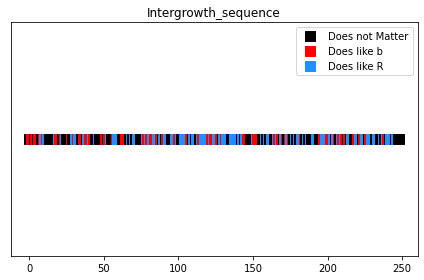

In [43]:
# Calculate the layer contribution value for each layer
Intergrowth_sequence_list = []
for i in range(4+Layers, 4+2*Layers-1):
    b_shap = np.sum((shap_values[np.where(X_train.values[:,i] == 1),i]))
    r_shap = np.sum((shap_values[np.where(X_train.values[:,i] == 0),i]))
    Intergrowth_sequence_list.append(b_shap - r_shap)

lower_percentile = 0
Pyr_blocks = np.where((np.array(Intergrowth_sequence_list) > lower_percentile) & (np.array(Intergrowth_sequence_list) > 0))[0]
Ram_blocks = np.where((np.array(Intergrowth_sequence_list) < lower_percentile) & (np.array(Intergrowth_sequence_list) < 0))[0]
print ("R-MnO2 sequences:", Ram_blocks)
print ("B-MnO2 Sequences:", Pyr_blocks)

count_b = 0
count_g = 0
count_r = 0
for i in range(Layers-1):
    if Intergrowth_sequence_list[i] == 0:
        color = "k"
        label = "Does not Matter"
        plt.plot(i, 0, "o", color=color, marker="s", markersize=10, label=label if count_b == 0 else "_nolegend_")
        count_b += 1
    elif Intergrowth_sequence_list[i] < lower_percentile:
        color = "g"
        label = "Does like R"
        plt.plot(i, 0, "o", color='dodgerblue', marker="s", markersize=10, label=label if count_g == 0 else "_nolegend_")
        count_g += 1
    elif Intergrowth_sequence_list[i] > lower_percentile:
        color = "r"
        label = "Does like b"
        plt.plot(i, 0, "o", color=color, marker="s", markersize=10, label=label if count_r == 0 else "_nolegend_")
        count_r += 1
        
# Plot the results
plt.yticks([], [])
plt.legend()
plt.title("Intergrowth_sequence")
plt.tight_layout()
plt.show()

# Calculate the stacking fault distributions

We only use the stacking faults sequence to calculate the domain size distributions.

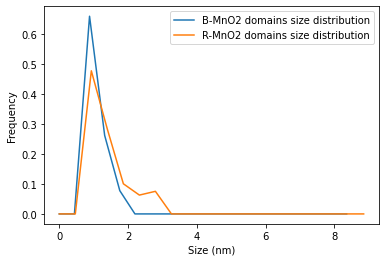

In [76]:
largest_possible_domain = 20 # Define the largest possible domain we are searching for
DSD_pyr = np.zeros(largest_possible_domain)        #Number of B-MnO2 domains of a given size
DSD_ram = np.zeros(largest_possible_domain)        #Number of R-MnO2 domains of a given size
x_array_pyr = np.array([i*0.44 for i in range(largest_possible_domain)])  #Calculate physical size of B-MnO2 domains (in nm)
x_array_ram = np.array([i*0.466 for i in range(largest_possible_domain)]) #Calculate physical size of R-MnO2 domains (in nm)

#Determines size of domains of B-MnO2 blocks, first in number of blocks, and then in physical size
block = 1
for i in range(len(Pyr_blocks)-1):
    if Pyr_blocks[i+1] == Pyr_blocks[i]+1:
        block += 1
    else:
        DSD_pyr[block+1] += 1
        block = 1
vol_pyr = np.sum(DSD_pyr * x_array_pyr)
DSD_pyr_vol = DSD_pyr * x_array_pyr / vol_pyr

#Determines size of domains of R-MnO2 blocks, first in number of blocks, and then in physical size    
block = 1 
for i in range(len(Ram_blocks)-1):
    if Ram_blocks[i+1]==Ram_blocks[i]+1:
        block +=1
    else:
        DSD_ram[block+1] += 1
        block = 1
vol_Ram = np.sum(DSD_ram * x_array_ram)
DSD_ram_vol = DSD_ram * x_array_ram / vol_Ram

# Plot the stacking fault domain size distributions
plt.plot(x_array_pyr, DSD_pyr_vol, label='B-MnO2 domains size distribution')
plt.plot(x_array_ram, DSD_ram_vol, label='R-MnO2 domains size distribution')
plt.xlabel('Size (nm)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Cite
If you use ML-MotEx to analyse the stacking fault distribution, please consider citing our papers. Thanks in advance!
```
@article{anker2022ML-MotEx,
title={Extracting Structural Motifs from Pair Distribution Function Data of Nanostructures using Explainable Machine Learning},
author={Andy S. Anker, Emil T. S. Kjær, Mikkel Juelsholt, Troels Lindahl Christiansen, Susanne Linn Skjærvø, Mads Ry Vogel Jørgensen, Innokenty Kantor, Daniel R. Sørensen, Simon J. L. Billinge, Raghavendra Selvan, Kirsten M. Ø. Jensen},
year={2022}}
```

```
@article{magnard2022Intergrowth,
title={Characterisation of intergrowth in metal oxide materials using structure-mining: the case of γ-MnO2},
author={Nicolas P. L. Magnard, Andy S. Anker, Andrea Kirsch, Kirsten M. Ø. Jensen},
year={2022}}
```

# LICENSE
This project is licensed under the Apache License Version 2.0, January 2004 - see the LICENSE file at https://github.com/AndySAnker/ML-MotEx/blob/main/LICENSE for details.